# Simple PV forecast based on scaled solar irradiance

This notebook shows how to use the `frequenz.client.weather` package to get solar irradiance forecasts and use it to create a simple PV forecast. The forecast scales the irradiance to the peak power of the PV system.

This approach ignores many of the major factors such as:
* orientation, tilt, location
* temperature, wind, snow, ...
* degradation of PV efficiency (could be approximated as a linear reduction)
* inverter control by apps such as feed-in limits

In [1]:
!pip install frequenz-client-weather==0.1.0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

In [3]:
from frequenz.client.weather._types import ForecastFeature, Location
from frequenz.client.weather._client import Client

In [ ]:
service_address = "grpc://weather.url.goes.here.example.com"  # Replace with a proper service address

start = datetime.fromisoformat("2025-03-01")
end = datetime.fromisoformat("2025-03-07")

# Weather parameter
features = [ForecastFeature.SURFACE_NET_SOLAR_RADIATION,]

# Location
latitude = 52.358611
longitude = 14.064167

# Peak power used for naive forecast (e.g. in Watts)
peak_power = 6e6 

In [6]:
client = Client(service_address)

In [7]:
locations = [
    Location(
        latitude=latitude,
        longitude=longitude,
        country_code="DE",
    ),
]

# Iterator over historical forecasts
location_forecast_iterator = client.hist_forecast_iterator(
    features=features, locations=locations, start=start, end=end
)

In [8]:
# Get the data as a flat list to create a DataFrame
wdata = [f.flatten() async for f in location_forecast_iterator]
wdata = [item for sublist in wdata for item in sublist]


In [10]:
# Convert to DataFrame
wdf = pd.DataFrame(wdata).sort_values(["creation_ts", "validity_ts", "latitude", "longitude", "feature"])
wdf = wdf[wdf["validity_ts"] - wdf["creation_ts"] < timedelta(hours=6)]
wdf

In [11]:
# There is just a single parameter and location so extract as series
ssr = wdf.set_index("validity_ts")["value"].rename("ssr")

<Axes: xlabel='validity_ts'>

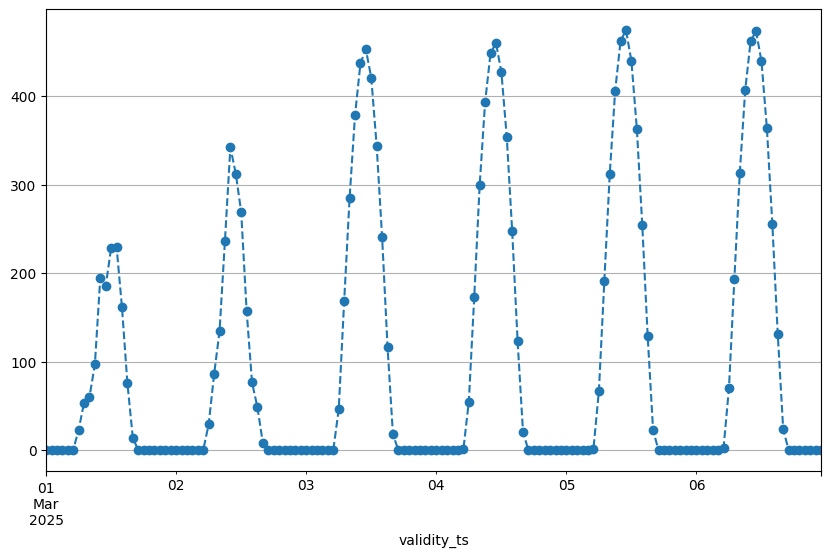

In [12]:
# Raw forecast hourly
ssr.plot(style="o--")

In [13]:
# Interpolate to 15 minutes
pvf = ssr.resample("15min").interpolate()
# Scale to peak power, divided by 1000 to normalize to STC: 
# https://de.wikipedia.org/wiki/Standard-Testbedingungen_(Photovoltaik)
pvf = pvf.rename("fc") * peak_power / 1000

<Axes: xlabel='validity_ts'>

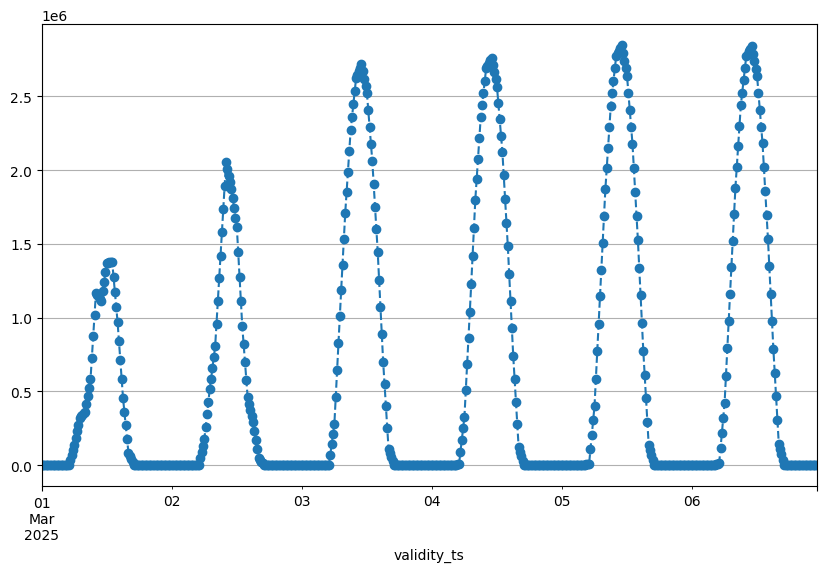

In [14]:
pvf.plot(style="o--")